## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality.csv",
     
    # model
   
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "nst",
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier.json"
}

In [2]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [4]:
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(config_dict['tokenizer'])

In [7]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data.head()

,Satz,Tokens,Klassierung,Bemerkungen
0,Leitthema Trauma Berufskrankh 2016 · 18:275–28...,"['leitthema', 'trauma', 'berufskrankh', '2016'...",REFERENCE,NaN
1,"für Wirbelsäulenchirurgie, Berufsgenossenschaf...","['für', 'wirbelsäulenchirurgie', 'berufsgenoss...",TITLE,NaN
2,83 mischten lympho-epithelialen ~eubildungen d...,"['83', 'mischten', 'lympho-epithelialen', 'eub...",LOW_QUALITY,NaN
3,iVikolaus G. Chlopin.,"['ivikolaus', 'g', 'chlopin']",REFERENCE,NaN
4,Langenbecks Archivf.rChirurgie Langenbecks Ar...,"['langenbecks', 'archivfrchirurgie', 'langenbe...",REFERENCE,NaN


In [23]:
data.loc[2]

Satz           83 mischten lympho-epithelialen ~eubildungen d...
Tokens         ['83', 'mischten', 'lympho-epithelialen', 'eub...
Klassierung                                          LOW_QUALITY
Bemerkungen                                                  NaN
Name: 2, dtype: object

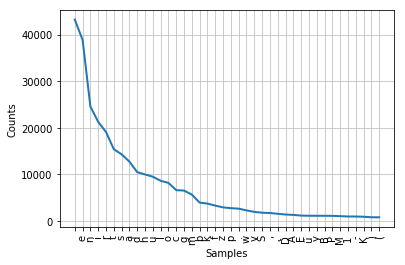

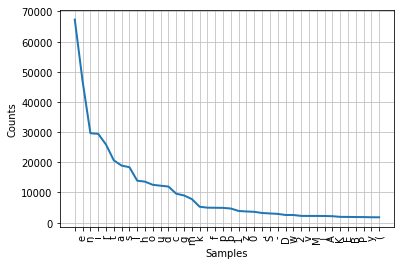

In [32]:
high_quality = data.loc[data['Klassierung'].isin(['SENTENCE'])]
low_quality = data.loc[[not a for a in data['Klassierung'].isin(['SENTENCE'])]]

fdc = nltk.FreqDist()
for s in high_quality['Satz']:
    fdc.update(s)
    
# character frequencies
fdc.plot(40,cumulative=False)

fdc2 = nltk.FreqDist()
for s in low_quality['Satz']:
    fdc2.update(s)
    
# character frequencies
fdc2.plot(40,cumulative=False)